In [1]:
#| echo: false
import pandas as pd
import numpy as np
import scipy.stats as stats
from tableone import TableOne
from types import NoneType
from turtle import color
from plotnine import ggplot, geom_point,geom_line,geom_violin, aes, theme, theme_bw
wd = '/Users/timvigers/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/CF/Edith Zemanick/CF Nutrition/'

In [2]:
# Import
# Modulator dates
mods = pd.read_excel(
    wd+"Data_Raw/Report CFTR Modulators_throughDecember2021.xlsx")
mods.sort_values(by=["Patient ID", "Earliest Date in Registry"],
                 ascending=True, inplace=True)
mods = mods[mods['Earliest Date in Registry'] != mods['Last Date in Registry']]
# vitemins
vit = pd.read_excel(
    wd+"Data_Raw/Report Vitamins_throughDecember2021_revised20220712.xlsx")
# Add FEV information
fev = pd.read_excel(wd+"Data_Raw/Report_PFTs_ThroughDecember2021.xlsx")
fev = fev.rename(columns={'PatientID': 'Patient ID'})
df = pd.merge(vit, fev, how="outer", on=["Patient ID", "Date"])

# Data Cleaning

In [3]:
df.sort_values(by=["Patient ID", "Date"], ascending=True, inplace=True)
# Get modulator at each vitamin measure, pre-/post- information, and start date
m = []
p = []
s = []
f = []
for r in range(df.shape[0]):
    # Get ID
    id = df.iloc[r, 0]
    # If no mod information, return NA
    if id not in mods["Patient ID"].unique():
        m.append(np.nan)
        p.append(np.nan)
        s.append(np.nan)
        f.append(np.nan)
        continue
    # Get row date
    date = df.iloc[r, 2]
    # Get modulator dates by ID
    mod = mods.loc[mods["Patient ID"] == id, :]
    dates = mod.iloc[:, 3]
    # Check which dates the row is after
    after = np.where(date > dates)[0]
    # If not after any, return no modulator
    if after.shape[0] == 0:
        m.append("None")
    else:
        m.append(mod.iloc[max(after), 1])
    # Check if pre-/post-effective modulator
    eff_mod = mod[(mod["Modulator"] == "Kalydeco") |
                  (mod["Modulator"] == "Trikafta")]
    if eff_mod.shape[0] > 0:
        start = eff_mod.iloc[0, 3]
        s.append(start)
        f.append(eff_mod.iloc[0, 1])
        if date <= start:
            p.append("Pre")
        else:
            p.append("Post")
    else:
        p.append(np.nan)
        s.append(np.nan)
        f.append(np.nan)
df["Modulator"] = m
df["Pre-/Post-Effective Modulator"] = p
df["Effective Modulator Start"] = s
df["Days From Start"] = (df["Date"] - df["Effective Modulator Start"]).dt.days
df["First Modulator"] = f
# Replace missing ages with info from PFT visit
df["Age at Test (years)"].fillna(df["Age At PFT (years)"],inplace=True)
# Fill sex info
df["Sex"] = df.groupby(["Patient ID"], sort=False)['Sex'].apply(lambda x: x.ffill().bfill())
# Drop those without modulator info
df.dropna(subset="Modulator", inplace=True)
# Limit to three years prior
df = df[df["Days From Start"] >= -3*365]
# Remove values less than 3 months after start
df = df[(df["Days From Start"] < 0) | (df["Days From Start"] >=90)]
# Write for checking
df.to_csv(wd+"Data_Cleaned/all.csv", index=False)


In [4]:
# Convert to numeric
cols = ["VitaminA_Retinol", "25OH-Vitamin D", "Vitamin E Alpha",
        "Vitamin E Gamma", "FEV1 % pred", "BMI percentile (CDC)"]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
# For each person, average all their pre-effective mod values
# but only use the most recent vitamin measure.
# If they have FEV1 or BMI within a month of the vitamin measure,
# use that otherwise missing
# Place to store results
analysis = {"ID": [], "Timepoint": [], "Vitamin A": [], "Vitamin D": [], "Vitamin E Alpha": [], "Vitamin E Gamma": [], "ppFEV1": [], "BMI Percentile": [],
            "First Modulator": [], "Age Nearest Modulator Start": [],"Sex":[]}
# Iterate through by ID
ids = df["Patient ID"].unique().tolist()
for id in ids:
    # Subset
    pre = df[(df["Patient ID"] == id) & (
        df["Pre-/Post-Effective Modulator"] == "Pre")]
    post = df[(df["Patient ID"] == id) & (
        df["Pre-/Post-Effective Modulator"] == "Post")]
    # Demographics (same for pre/post so append twice)
    # First modulator
    analysis["First Modulator"].append(
        df[df["Patient ID"] == id].iloc[0, df.shape[1]-1])
    analysis["First Modulator"].append(
        df[df["Patient ID"] == id].iloc[0, df.shape[1]-1])
    # Age at modulator start
    age = pre["Age at Test (years)"].last_valid_index()
    if (type(age) == NoneType):
        age_val = np.nan
    else:
        age_val = pre["Age at Test (years)"].loc[age]
    analysis["Age Nearest Modulator Start"].append(age_val)
    analysis["Age Nearest Modulator Start"].append(age_val)
    # Sex
    sex = df[df["Patient ID"] == id]
    analysis["Sex"].append(sex["Sex"].unique()[0])
    analysis["Sex"].append(sex["Sex"].unique()[0])
    # Pre
    analysis["ID"].append(id)
    analysis["Timepoint"].append("Pre")
    analysis["Vitamin A"].append(pre["VitaminA_Retinol"].mean(skipna=True))
    analysis["Vitamin D"].append(pre["25OH-Vitamin D"].mean(skipna=True))
    analysis["Vitamin E Alpha"].append(
        pre["Vitamin E Alpha"].mean(skipna=True))
    analysis["Vitamin E Gamma"].append(
        pre["Vitamin E Gamma"].mean(skipna=True))
    analysis["ppFEV1"].append(pre["FEV1 % pred"].mean(skipna=True))
    analysis["BMI Percentile"].append(
        pre["BMI percentile (CDC)"].mean(skipna=True))
    # Post
    analysis["ID"].append(id)
    analysis["Timepoint"].append("Post")
    # Most recent vitamin A
    vita = post["VitaminA_Retinol"].last_valid_index()
    if (type(vita) == NoneType):
        vita_value = np.nan
        vita_date = np.nan
    else:
        vita_value = post["VitaminA_Retinol"].loc[vita]
        vita_date = post["Date"].loc[vita]
    # Vitamin D
    vitd = post["25OH-Vitamin D"].last_valid_index()
    if (type(vitd) == NoneType):
        vitd_value = np.nan
        vitd_date = np.nan
    else:
        vitd_value = post["25OH-Vitamin D"].loc[vitd]
        vitd_date = post["Date"].loc[vitd]
    # Vitamin e
    # Alpha
    vitea = post["Vitamin E Alpha"].last_valid_index()
    if (type(vitea) == NoneType):
        vitea_value = np.nan
        vitea_date = np.nan
    else:
        vitea_value = post["Vitamin E Alpha"].loc[vitea]
        vitea_date = post["Date"].loc[vitea]
    # Gamma
    viteg = post["Vitamin E Gamma"].last_valid_index()
    if (type(viteg) == NoneType):
        viteg_value = np.nan
        viteg_date = np.nan
    else:
        viteg_value = post["Vitamin E Gamma"].loc[viteg]
        viteg_date = post["Date"].loc[viteg]
    # Check if there is a BMI and FEV1 value within 1 month of latest vitamin measure
    if all(pd.isnull([vita_date, vitd_date, vitea_date])):
        analysis["Vitamin A"].append(np.nan)
        analysis["Vitamin D"].append(np.nan)
        analysis["Vitamin E Alpha"].append(np.nan)
        analysis["Vitamin E Gamma"].append(np.nan)
        analysis["ppFEV1"].append(np.nan)
        analysis["BMI Percentile"].append(np.nan)
        continue
    else:
        vita_date = pd.to_datetime(vita_date, errors="coerce")
        vitd_date = pd.to_datetime(vitd_date, errors="coerce")
        vitea_date = pd.to_datetime(vitea_date, errors="coerce")
    # BMI
    bmi = post.dropna(subset="BMI percentile (CDC)")
    if bmi.shape[0] > 0:
        bmi = bmi[(abs((bmi["Date"] - vita_date).dt.days) <= 30) | (abs((bmi["Date"] -
                                                                         vitd_date).dt.days) <= 30) | (abs((bmi["Date"] - vitea_date).dt.days) <= 30)]
        if bmi.shape[0] > 0:
            bmi_ind = bmi["BMI percentile (CDC)"].last_valid_index()
            bmi_value = post["BMI percentile (CDC)"].loc[bmi_ind]
            bmi_date = post["Date"].loc[bmi_ind]
        else:
            bmi_value = np.nan
            bmi_date = np.nan
    else:
        bmi_value = np.nan
        bmi_date = np.nan
    # Check if there is a fev value within 1 month
    fev = post.dropna(subset='FEV1 % pred')
    if fev.shape[0] > 0:
        fev = fev[(abs((fev["Date"] - vita_date).dt.days) <= 30) | (abs((fev["Date"] -
                                                                         vitd_date).dt.days) <= 30) | (abs((fev["Date"] - vitea_date).dt.days) <= 30)]
        if fev.shape[0] > 0:
            fev_ind = fev['FEV1 % pred'].last_valid_index()
            fev_value = post['FEV1 % pred'].loc[fev_ind]
            fev_date = post["Date"].loc[fev_ind]
        else:
            fev_value = np.nan
            fev_date = np.nan
    else:
        fev_value = np.nan
        fev_date = np.nan
    # Add to results
    analysis["Vitamin A"].append(vita_value)
    analysis["Vitamin D"].append(vitd_value)
    analysis["Vitamin E Alpha"].append(vitea_value)
    analysis["Vitamin E Gamma"].append(viteg_value)
    analysis["ppFEV1"].append(fev_value)
    analysis["BMI Percentile"].append(bmi_value)
# Convert to DF
analysis = pd.DataFrame(analysis)
analysis.to_csv(wd+"Data_Cleaned/analysis.csv", index=False)


- All vitamin, PFT, and BMI percentile values were converted to numeric, so values such as "LESS THAN 0.4" were marked as missing.
- We excluded visits more than 3 years prior to effective modulator start and within 90 after effective modulator start.
- All values prior to effective modulator start were averaged to calculate the "pre" value. We selected the most recent vitamin values as the "post" value, and included any BMI percentile and FEV1 % predicted measures within a month of that visit.
- Sex was only included in the PFT datasheet, so those without PFT data were missing this variable.

# Results
## Table 1: Participant characteristics at most recent visit prior to modulator start

In [5]:
columns = ['Vitamin A', 'Vitamin D', 'Vitamin E Alpha','Vitamin E Gamma', 'ppFEV1', 'BMI Percentile','Age Nearest Modulator Start', 'Sex']
categorical = ["Sex"]
groupby = ['First Modulator']
nonnormal = ['Vitamin D']
table1 = TableOne(analysis[analysis["Timepoint"]=="Pre"], columns, categorical, groupby,nonnormal,normal_test = True,dip_test=True,tukey_test=True)
table1

Grouped by First Modulator                                                      
                                                                 Missing           Overall          Kalydeco          Trikafta
n                                                                                      190                54               136
Vitamin A, mean (SD)                                                  32       41.4 (10.8)        37.8 (9.9)       42.5 (10.8)
Vitamin D, median [Q1,Q3]                                             39  39.6 [34.4,46.7]  46.7 [39.3,53.0]  38.9 [32.7,44.4]
Vitamin E Alpha, mean (SD)                                            31        10.8 (3.8)        12.5 (3.6)        10.3 (3.8)
Vitamin E Gamma, mean (SD)                                           168         1.1 (0.4)         1.1 (0.5)         1.1 (0.5)
ppFEV1, mean (SD)                                                     28       89.8 (18.7)       93.7 (11.5)       88.9 (20.0)
BMI Percentile, mean (SD)                                             28       48.8 (23.5)       46.4 (22.5)       49.4 (23.8)
Age Nearest Modulator Start, mean (SD)                                 3        12.9 (5.7)         8.4 (6.5)        14.6 (4.2)
Sex, n (%)                             Female                         13         93 (52.5)         24 (57.1)         69 (51.1)
                                       Male                                      84 (47.5)         18 (42.9)         66 (48.9)
[1] Hartigan's Dip Test reports possible
                                  multimodal distributions for: Age Nearest Modulator Start.
[2] Normality test reports non-normal
                                  distributions for: Vitamin D.

## Change from pre- to post-modulator
- Pre- and post-modulator values were compared using the Wilcoxon signed rank test (the non-parametric equivalent of a paired t test).
- Figures include violin plots to the left and right of pre- and post-modulator values.

### Table 2

In [6]:
# Timepoint as categorical
analysis['Timepoint'] = pd.Categorical(analysis["Timepoint"],ordered=True,categories=["Pre","Post"])
# Medians
columns = ['Vitamin A', 'Vitamin D', 'Vitamin E Alpha',
           'Vitamin E Gamma', 'ppFEV1', 'BMI Percentile']
groupby = ['Timepoint']
table2 = TableOne(analysis, columns, groupby=groupby,nonnormal=columns)
table2

Grouped by Timepoint                                                          
                                              Missing            Overall                Pre                Post
n                                                                    380                190                 190
Vitamin A, median [Q1,Q3]                         111   41.0 [35.0,49.0]   40.7 [35.0,48.5]    42.0 [35.0,49.5]
Vitamin D, median [Q1,Q3]                         112   39.6 [32.1,49.6]   39.6 [34.4,46.7]    39.9 [29.5,53.8]
Vitamin E Alpha, median [Q1,Q3]                   108    10.2 [7.5,13.4]    10.4 [8.3,13.2]      9.9 [6.6,13.4]
Vitamin E Gamma, median [Q1,Q3]                   353      1.1 [0.8,1.4]      1.1 [0.7,1.3]       1.1 [0.9,1.8]
ppFEV1, median [Q1,Q3]                            126  96.0 [83.0,105.0]  93.0 [78.9,101.9]  100.5 [89.8,109.5]
BMI Percentile, median [Q1,Q3]                    131   53.9 [31.1,73.5]   52.9 [31.0,65.6]    58.8 [33.5,80.2]

Changes in vitamin A, vitamin D, and vitamin E gamma were not significant. Differences in vitamin E alpha (p = 0.024), FEV1 percent predicted (p < 0.001), and BMI percentile were statistically significant (p = 0.026).

### Figures

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 111 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 111 rows containing missing values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 112 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 112 rows containing missing values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_ydensity : Removed 108 rows containing non-finite values.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py

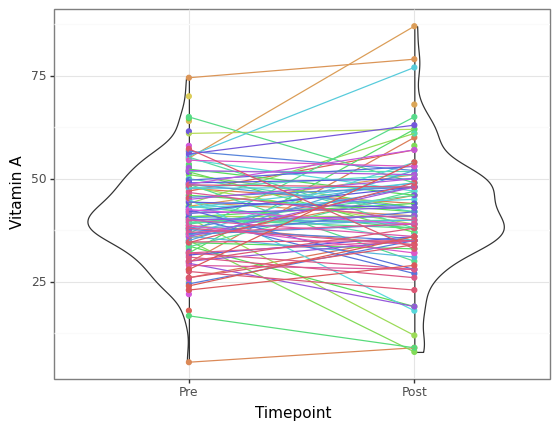

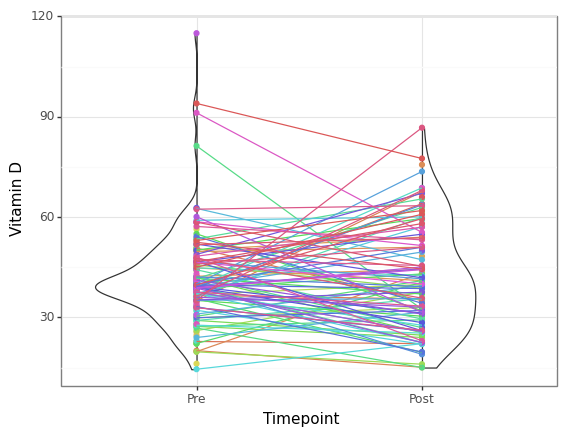

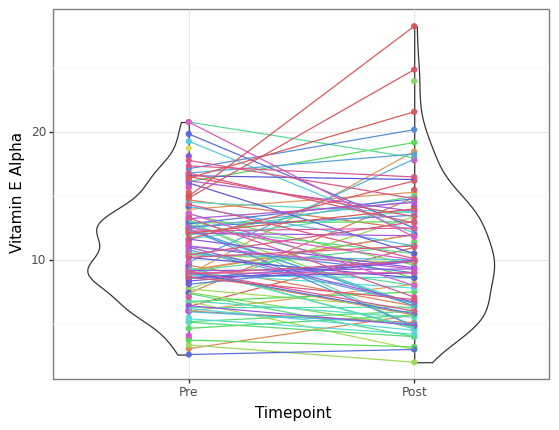

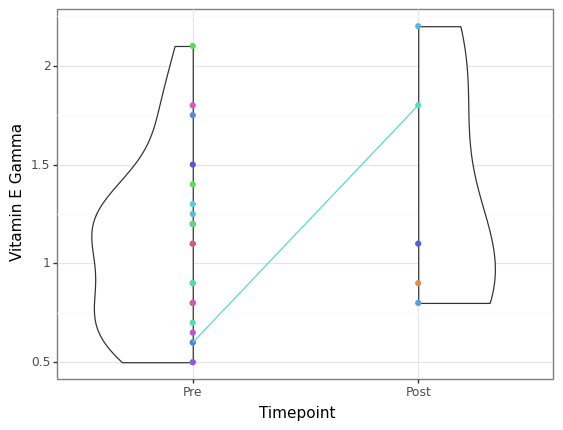

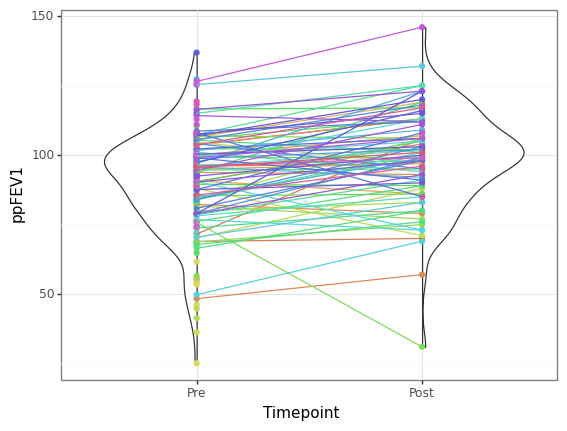

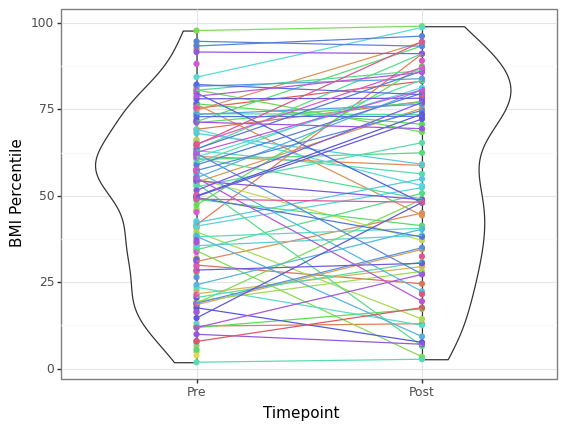

In [7]:
#| warning: true
#| output: false
plot = analysis.copy()
# Plot all variables
vita_plot = (ggplot(plot, aes('Timepoint', 'Vitamin A'))
 + geom_violin(style='left-right')
 + geom_point(aes(color = "factor(ID)",group = "factor(ID)")) + geom_line(aes(color = "factor(ID)",group = "factor(ID)"))
 + theme_bw()
 + theme(legend_position='none')).draw();
vitd_plot = (ggplot(plot, aes('Timepoint', 'Vitamin D'))
 + geom_violin(style='left-right')
 + geom_point(aes(color = "factor(ID)",group = "factor(ID)")) + geom_line(aes(color = "factor(ID)",group = "factor(ID)"))
 + theme_bw()
 + theme(legend_position='none')).draw();
vitea_plot = (ggplot(plot, aes('Timepoint', 'Vitamin E Alpha'))
 + geom_violin(style='left-right')
 + geom_point(aes(color = "factor(ID)",group = "factor(ID)")) + geom_line(aes(color = "factor(ID)",group = "factor(ID)"))
 + theme_bw()
 + theme(legend_position='none')).draw();
viteg_plot = (ggplot(plot, aes('Timepoint', 'Vitamin E Gamma'))
 + geom_violin(style='left-right')
 + geom_point(aes(color = "factor(ID)",group = "factor(ID)")) + geom_line(aes(color = "factor(ID)",group = "factor(ID)"))
 + theme_bw()
 + theme(legend_position='none')).draw();
fev_plot = (ggplot(plot, aes('Timepoint', 'ppFEV1'))
 + geom_violin(style='left-right')
 + geom_point(aes(color = "factor(ID)",group = "factor(ID)")) + geom_line(aes(color = "factor(ID)",group = "factor(ID)"))
 + theme_bw()
 + theme(legend_position='none')).draw();
bmi_plot = (ggplot(plot, aes('Timepoint', 'BMI Percentile'))
 + geom_violin(style='left-right')
 + geom_point(aes(color = "factor(ID)",group = "factor(ID)")) + geom_line(aes(color = "factor(ID)",group = "factor(ID)"))
 + theme_bw()
 + theme(legend_position='none')).draw();

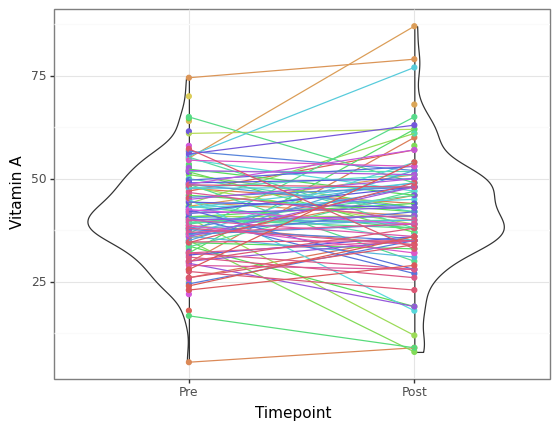

In [8]:
#| echo: false
vita_plot

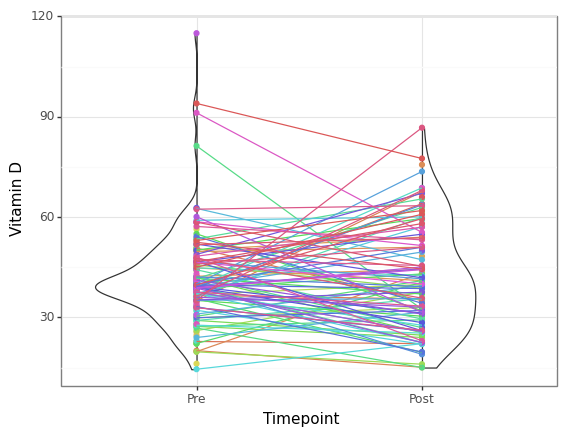

In [9]:
#| echo: false
vitd_plot

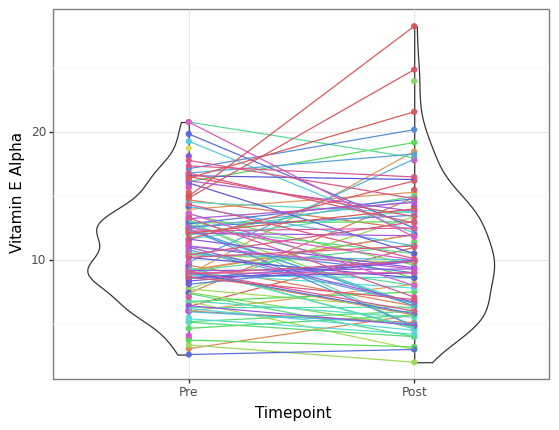

In [10]:
#| echo: false
vitea_plot

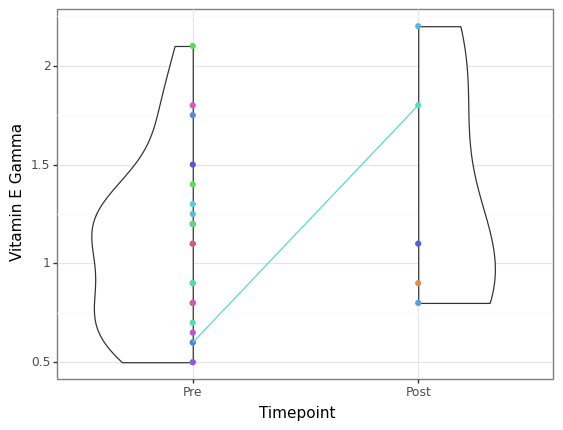

In [11]:
#| echo: false
viteg_plot

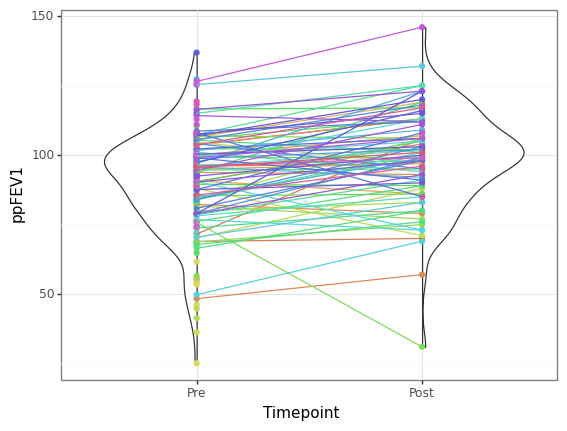

In [12]:
#| echo: false
fev_plot

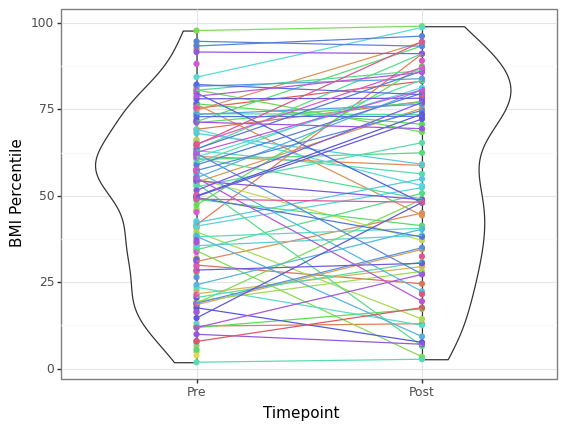

In [13]:
#| echo: false
bmi_plot